# **Quadrature Squeezing Enhances Wigner Negativity**

In the paper they apply the (simplified) Hamiltonian
$$
H = \hbar g \left( \hat{n}^2 - \hat{n} \right) \Rarr \approx \text{KGate}(g dt) \text{RGate}(-g dt)


$$

In [2]:
import strawberryfields as sf
from strawberryfields.ops import *

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm

In [3]:
""" Plotting """
def plot_wigner_2d(state, title = "Wigner Function of State", range = 20):
    fig = plt.figure()
    x = np.linspace(-range, range, 100)
    p = np.linspace(-range, range, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    ax = fig.add_subplot(111)
    contour = ax.contourf(X, P, Z, cmap='RdYlGn')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    # add colorbar
    cbar = plt.colorbar(contour)
    cbar.set_label('Wigner Function')
    
    fig.tight_layout()
    
    plt.show()
    
def plot_wigner(state, title = "Wigner Function of State", range = 20):
    fig = plt.figure()
    x = np.linspace(-range, range, 100)
    p = np.linspace(-range, range, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, P, Z, cmap='RdYlGn', lw=0.5, rstride=1, cstride=1)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    fig.tight_layout()

In [4]:
""" Hyperparameters """
N = 10
CUTOFF = 60
RANGE = 10
gT = 0.008 # scaled duration (gt)

""" Run parameters"""
gdt = gT / N # scaled time step (gdt) will be used later in plotting
Ns = range(0, N+1) 
gts = [gdt * n for n in Ns] # scaled time steps

s = [2, 2.5, 3, 3.5, 4, 4.5, 5]
rs = np.array(np.log(s)) # scaled nonlinearity (r) will be used later in plotting


""" Define run functions"""

def negativity(state, range):
    # for wigner function state.wigner() integrate over the range including only negative values
    x = np.linspace(-range, range, 100)
    p = np.linspace(-range, range, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    # find the negative values
    Z[Z > 0] = 0
    # integrate over the range
    Z = np.trapz(np.trapz(Z, x), p)

    return -Z


def run(r): # get curve for one value of r
    eng = sf.Engine("fock", backend_options={"cutoff_dim": CUTOFF})
    negs = [] # will be filled with N+1 values of negativity, n = 0 (no nonlinearity), n = N (full nonlinearity)
    for n in Ns:
        # run until gdt * n
        prog = sf.Program(1)
        with prog.context as q:
            # Apply the gate
            Sgate(r, np.pi) | q[0]
            
            for i in range(n):
                Kgate(gdt) | q[0]
                Rgate(-gdt) | q[0]

        state = eng.run(prog).state
        negs.append(negativity(state, RANGE))
        eng.reset()
    return negs
    
    

""" Run sequence """
neg_lists = []
for r in tqdm(rs):
    negs = run(r)
    neg_lists.append(negs)

100%|██████████| 7/7 [00:26<00:00,  3.83s/it]


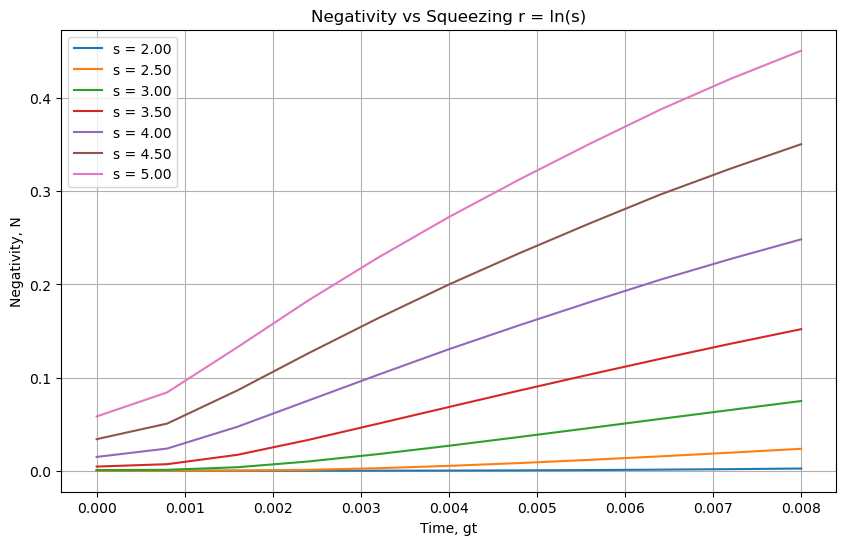

In [5]:
""" Plotting """
fig = plt.figure(figsize=(10, 6))
for i, r in enumerate(rs):
    plt.plot(gts, neg_lists[i], label = f's = {s[i]:.2f}')
plt.xlabel('Time, gt')
plt.ylabel('Negativity, N')
plt.title('Negativity vs Squeezing r = ln(s)')
plt.legend()
plt.grid()
plt.show()

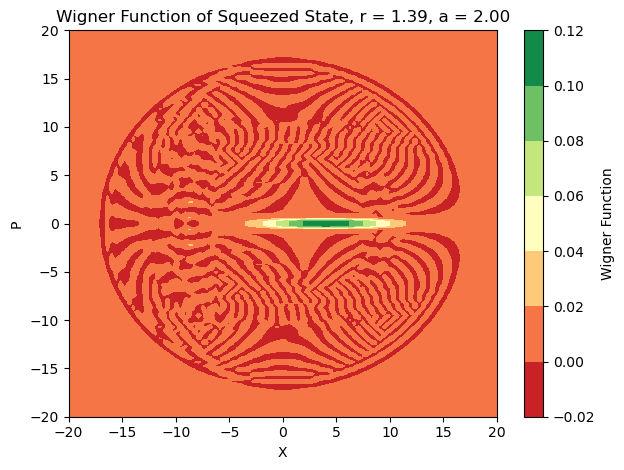

In [6]:
# def run_s(r): # get curve for one value of r
    
#     prog = sf.Program(1)
#     with prog.context as q:
#         # Apply the gate
#         Sgate(r, 0) | q[0]
        
#         eng = sf.Engine("fock", backend_options={"cutoff_dim": CUTOFF})
#         state = eng.run(prog).state
        
#     return negativity(state, RANGE)
    
# print(run_s(np.log(4)))

def plot_example(r, a):
    prog = sf.Program(1)
    with prog.context as q:
        Sgate(r, np.pi) | q[0]
        Dgate(a) | q[0]
        
        eng = sf.Engine("fock", backend_options={"cutoff_dim": 80})
        state = eng.run(prog).state
        
    plot_wigner_2d(state, title = f'Wigner Function of Squeezed State, r = {r:.2f}, a = {a:.2f}')
    
plot_example(np.log(4), 2) # example plot for r = ln(4), a = 0.5

### **Add Displacement**

In [7]:
""" Hyperparameters """
N = 10
CUTOFF = 60
RANGE = 10
gT = 0.008 # scaled duration (gt)

""" Run parameters"""
gdt = gT / N # scaled time step (gdt) will be used later in plotting
Ns = range(0, N+1) 
gts = [gdt * n for n in Ns] # scaled time steps

s = [2, 2.5, 3, 3.5, 4, 4.5, 5]
rs = np.array(np.log(s)) # scaled nonlinearity (r) will be used later in plotting


def run_displacement(r, a): # get curve for one value of r
    eng = sf.Engine("fock", backend_options={"cutoff_dim": CUTOFF})
    negs = [] # will be filled with N+1 values of negativity, n = 0 (no nonlinearity), n = N (full nonlinearity)
    for n in Ns:
        # run until gdt * n
        prog = sf.Program(1)
        with prog.context as q:
            # Apply the gate
            Sgate(r, np.pi) | q[0]
            Dgate(a) | q[0]
            
            for i in range(n):
                Kgate(gdt) | q[0]
                Rgate(-gdt) | q[0]

        state = eng.run(prog).state
        negs.append(negativity(state, RANGE))
        eng.reset()
    return negs


Keeping $\alpha$ constant and changing squeezing

100%|██████████| 7/7 [00:18<00:00,  2.65s/it]


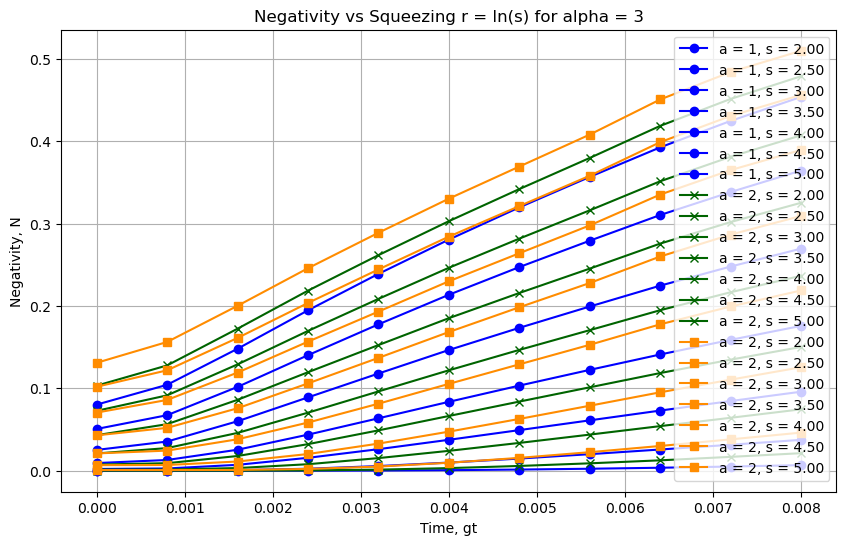

In [8]:
""" Run sequence 1 """
a = 1
neg_lists_1 = []
for r in tqdm(rs):
    negs = run_displacement(r, a)
    neg_lists_1.append(negs)


""" Run sequence 2 """
a = 2
neg_lists_2 = []
for r in tqdm(rs):
    negs = run_displacement(r, a)
    neg_lists_2.append(negs)
    
""" Run sequence 3 """
a = 3
neg_lists_3 = []
for r in tqdm(rs):
    negs = run_displacement(r, a)
    neg_lists_3.append(negs)


""" Plotting """
fig = plt.figure(figsize=(10, 6))
for i, r in enumerate(rs):
    plt.plot(gts, neg_lists_1[i], label = f'a = 1, s = {s[i]:.2f}', marker = 'o', color = 'blue')
for i, r in enumerate(rs):
    plt.plot(gts, neg_lists_2[i], label = f'a = 2, s = {s[i]:.2f}', marker = 'x', color = 'darkgreen')
for i, r in enumerate(rs):
    plt.plot(gts, neg_lists_3[i], label = f'a = 2, s = {s[i]:.2f}', marker = 's', color = 'darkorange')
plt.xlabel('Time, gt')
plt.ylabel('Negativity, N')
plt.title('Negativity vs Squeezing r = ln(s) for alpha = {}'.format(a))
plt.legend()
plt.grid()
plt.show()

Keeping squeezing constant $s = 4$ and changing displacement

100%|██████████| 7/7 [00:18<00:00,  2.70s/it]


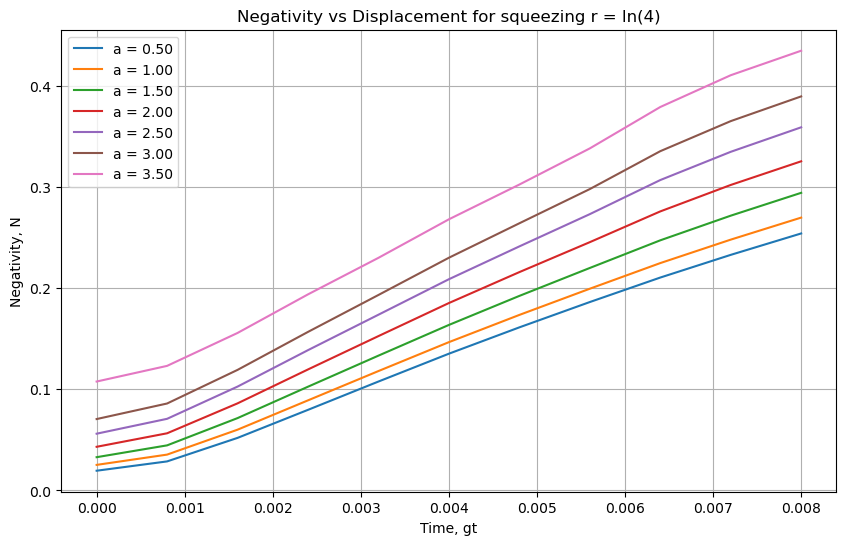

In [9]:
""" Run sequence """
a_list = np.linspace(0.5, 3.5, 7)
r = np.log(4)
neg_lists = []
for a in tqdm(a_list):
    negs = run_displacement(r, a)
    neg_lists.append(negs)
    
""" Plotting """
fig = plt.figure(figsize=(10, 6))
for i, a in enumerate(a_list):
    plt.plot(gts, neg_lists[i], label = f'a = {a_list[i]:.2f}')
plt.xlabel('Time, gt')
plt.ylabel('Negativity, N')
plt.title('Negativity vs Displacement for squeezing r = ln(4)')
plt.legend()
plt.grid()
plt.show()

### **Adding Loss**

We assume that $g$ here is analogous to nonlinearity coefficient $\chi$ in Kerr Hamiltonian. Thus we **define the loss coefficient $\kappa$** through the ratio
$$
\gamma = \frac{g}{k}
$$
such that the transmission coefficient for the Strawberry Fields Loss Gate $T$ is given by 
$$
T = e^{-\kappa dt} = e^{-\frac{gdt}{\gamma}}
$$

Thus the larger the ratio $\gamma$ the smaller less loss we have.

  0%|          | 0/5 [00:00<?, ?it/s]

Running for s = 4, gamma = 100


 20%|██        | 1/5 [00:11<00:45, 11.36s/it]

Running for s = 4, gamma = 1


 40%|████      | 2/5 [00:22<00:33, 11.30s/it]

Running for s = 4, gamma = 0.5


 60%|██████    | 3/5 [00:33<00:22, 11.25s/it]

Running for s = 4, gamma = 0.1


 80%|████████  | 4/5 [00:45<00:11, 11.35s/it]

Running for s = 4, gamma = 0.01


100%|██████████| 5/5 [00:56<00:00, 11.34s/it]


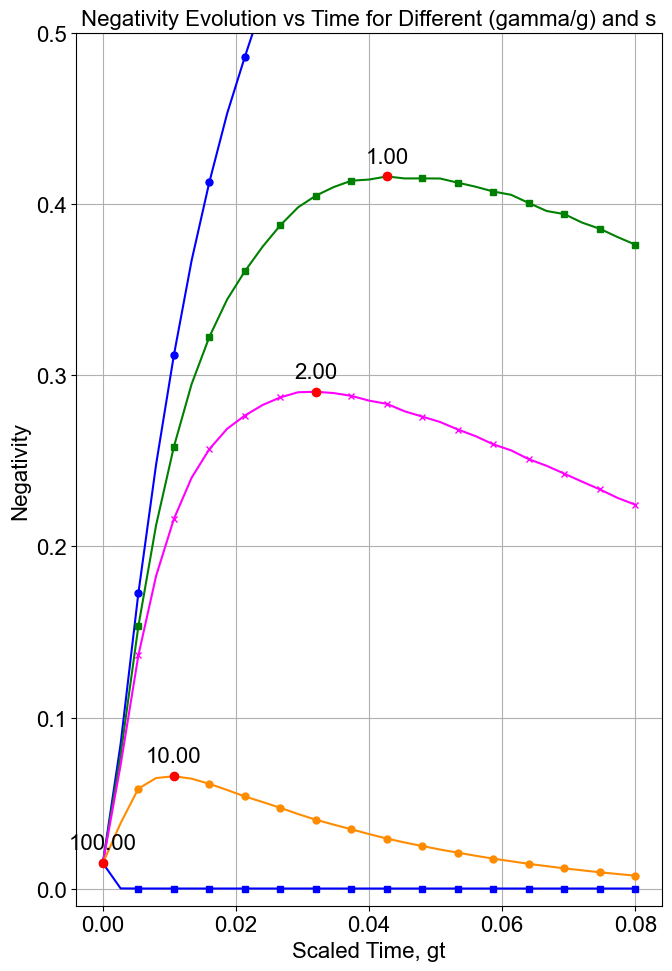

In [21]:
""" Hyperparameters """
N = 30
CUTOFF = 60
RANGE = 10
gT = 0.080 # scaled duration (gt)

""" Run parameters"""
gdt = gT / N # scaled time step (gdt) will be used later in plotting
Ns = range(0, N+1) 
gts = [gdt * n for n in Ns] # scaled time steps

s = [4]
rs = np.array(np.log(s)) # scaled nonlinearity (r) will be used later in plotting

gammas = [100, 1, 0.5, 0.1, 0.01]


def run_loss(r, gamma):  # gamma = g/k
    eng = sf.Engine("fock", backend_options={"cutoff_dim": CUTOFF})
    negs = []

    # Calculate the transmission coefficient per time step
    T = np.exp(-gdt / gamma)

    for n in Ns:
        prog = sf.Program(1)
        with prog.context as q:
            Sgate(r, np.pi) | q[0]
            
            for i in range(n):
                Kgate(gdt) | q[0]
                Rgate(-gdt) | q[0]
                LossChannel(T) | q[0]  # Apply loss after each small time step

        state = eng.run(prog).state
        negs.append(negativity(state, RANGE))
        eng.reset()
    return negs

""" Run sequence """
negativity_data = {}  # structure: {(s_val, gamma): [neg_t0, neg_t1, ..., neg_tN]}

for gamma in tqdm(gammas):
    for i, r in enumerate(rs):
        s_val = s[i]
        print(f"Running for s = {s_val}, gamma = {gamma}")
        negs = run_loss(r, gamma)
        negativity_data[(s_val, gamma)] = negs
    

""" Plotting """
gamma_colors = ['blue', 'green', 'magenta', 'darkorange']
gamma_markers = ['o', 's', 'x']

fig = plt.figure(figsize=(7, 10))
# set font to Arial, size 12
plt.rc('font', family='Arial', size=16)
plt.rc('axes', titlesize=16)  # fontsize of the axes title

for g_idx, gamma in enumerate(gammas):
    color = gamma_colors[g_idx % len(gamma_colors)]
    marker = gamma_markers[g_idx % len(gamma_markers)]

    for s_val in s: 
        negs = negativity_data.get((s_val, gamma), None)
        if negs is None:
            continue
        label = f's = {s_val}, γ = {gamma}'
        plt.plot(gts, negs, label=label,
                color=color,
                marker=marker,
                markevery=2,
                markersize=5,
                linewidth=1.5)
        # plot maximum point
        max_idx = np.argmax(negs)
        plt.plot(gts[max_idx], negs[max_idx], 'ro')
        # annotate with ratio
        plt.annotate(f'{1/gamma:.2f}', (gts[max_idx], negs[max_idx]), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Scaled Time, gt')
plt.ylabel('Negativity')
plt.title('Negativity Evolution vs Time for Different (gamma/g) and s')
plt.ylim(-0.01, 0.5)
plt.grid(True)
#plt.legend()
plt.tight_layout()
plt.show()